This program will download a list of all the Policy Research Working Papers from the World Bank. Get the abstracts, titles, and authors, then apply the data use in academia model to classify data use and country of study.

In [39]:
#load libraries
import numpy as np
import pandas as pd
import os
import glob
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import pipeline, PreTrainedModel, PreTrainedTokenizer, AutoConfig
from plotnine import ggplot, aes, geom_line, labs, facet_wrap, geom_point, geom_text, scale_x_log10, scale_y_log10
import country_converter as coco #https://pypi.org/project/country-converter/ #pip install country_converter --upgrade
import ast
import re 
import torch
from tqdm import tqdm

#set path using os
path = os.getcwd()
#strip 02_programs from end of path
root_path=path[:-16]


First, read in the list of policy research working papers using the World Bank document API.

In [40]:
api_url = 'https://search.worldbank.org/api/v2/wds?format=json&strdate=2010-01-01&docty_key=620265&rows=40000&fl=abstracts,authr,alt_title,colti,closedt,count,display_title,docdt,docna,docty,entityid,envcat,geo_reg,id,isbn,issn,keywd,majdocty,origu'

#read in json file and normalize it
df = pd.read_json(api_url)
df = pd.json_normalize(df['documents'])

#I need to do this in batches by year. I will start with 2000-2024
#I will create a list of years
years = list(range(2000,2025))

#create api request with strdate changing by year and enddate changing by year
filepath=os.path.join(root_path + '01_raw_data','prwp_papers')

for year in years:
    #add filename to filepath
    filename='prwp_' + str(year) + '.csv'
    file=os.path.join(filepath,filename)    
    #skip if file already exists
    if os.path.exists(file):
        continue
    else:
        api_url = 'https://search.worldbank.org/api/v2/wds?format=json&strdate=' + str(year) + '-01-01&enddate=' + str(year) + '-12-31&docty_key=620265&rows=40000&fl=abstracts,authr,alt_title,colti,closedt,count,display_title,docdt,docna,docty,entityid,envcat,geo_reg,id,isbn,issn,keywd,majdocty,origu'
        df = pd.read_json(api_url)
        df = pd.json_normalize(df['documents'])

        df.to_csv(file) #save to csv
    
    print('Finished ' + str(year))

#I will now combine all the files into one
prwp_df = pd.DataFrame()
for year in years:
    temp_df = pd.read_csv(root_path + '/01_raw_data/prwp_papers/prwp_' + str(year) + '.csv')
    prwp_df = pd.concat([prwp_df, temp_df])




Now I will load a pretrained model to classify data use of the articles.

In [41]:
#load the machine learning model
#creat path to model

model_path=os.path.join(root_path + '01_raw_data','data_use_model')
model = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Check if a GPU is available and if not, use a CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move the model to the GPU
model.to(device)


def apply_pipeline_old(text):
    inputs = tokenizer(text, truncation=True, padding='max_length', max_length=512)
    inputs = {name: torch.tensor(data).to(device) for name, data in inputs.items()}
    outputs = model(**inputs)
    return outputs

def apply_pipeline(text):
    # Truncate the text to the maximum length
    text = text[:512]
    
    # Create the pipeline
    my_pipeline = pipeline("text-classification", model=model, tokenizer=tokenizer)
    
    # Use the pipeline to get the outputs
    outputs = my_pipeline(text)
    
    return outputs


In [42]:
#prepare the data to use the NLP model
#create a new column with the title and abstract appended
prwp_df['prompt_text'] = 'Title: ' + prwp_df['display_title'].astype(str) + '. Abstract: ' + prwp_df['abstracts.cdata!'].astype(str)

In [43]:
def chunkslong(txt):  
    # Tokenize the input text with special tokens
    tokens = tokenizer.encode_plus(txt, add_special_tokens=False, return_tensors='pt')

    # Define the target chunk size
    chunksize = 512

    # Split the tokenized text into chunks of 510 tokens each
    input_id_chunks = list(tokens['input_ids'][0].split(chunksize - 2))
    mask_chunks = list(tokens['attention_mask'][0].split(chunksize - 2))

    # Loop through each chunk
    for i in range(len(input_id_chunks)):
        # Add [CLS] and [SEP] tokens to input IDs
        input_id_chunks[i] = torch.cat([
            torch.tensor([101]).float(), input_id_chunks[i].float(), torch.tensor([102]).float()
        ])
        # Add attention tokens to attention mask
        mask_chunks[i] = torch.cat([
            torch.tensor([1]).float(), mask_chunks[i].float(), torch.tensor([1]).float()
        ])
        # Calculate the required padding length
        pad_len = chunksize - input_id_chunks[i].shape[0]
        # If padding length is more than 0, add padding
        if pad_len > 0:
            input_id_chunks[i] = torch.cat([
                input_id_chunks[i].float(), torch.Tensor([0] * pad_len).float()
            ])
            mask_chunks[i] = torch.cat([
                mask_chunks[i].float(), torch.Tensor([0] * pad_len).float()
            ])

    # Convert the chunks into tensors
    input_ids = torch.stack(input_id_chunks)
    attention_mask = torch.stack(mask_chunks)

    # Create a dictionary to hold the input tensors
    input_dict = {
        'input_ids': input_ids.long(),
        'attention_mask': attention_mask.int()
    }

    # Feed the input tensors into the model
    outputs = model(**input_dict)

    # Apply softmax to the model's output to get probabilities
    probs = torch.nn.functional.softmax(outputs[0], dim=-1)

    # Average the probabilities across all chunks
    probs = probs.mean(dim=0)

    # Get the label with the highest average probability
    winner = torch.argmax(probs).item()

    # Return the winning label
    return ['LABEL_0','LABEL_1'][winner]

In [44]:
#apply the pipeline to the prompt text and return output in a new column
prwp_df = prwp_df.reset_index(drop=True)

tqdm.pandas()

chunk_size = 250  # Adjust this value to fit your GPU memory
num_chunks = len(prwp_df) // chunk_size + (len(prwp_df) % chunk_size != 0)

#split the data into chunks then run the model and save in each iteration. After completed, combine all the files

#measure progress with tqdm

for i in tqdm(range(num_chunks)):
    # Add filename to filepath
    filename = 'prwp_' + str(i) + '.csv'
    file = os.path.join(filepath, "temp", filename)    
    chunk = prwp_df.iloc[i*chunk_size:(i+1)*chunk_size]
        
    # Apply the pipeline or chunkslong function depending on the token length
    chunk['output'] = chunk['prompt_text'].apply(lambda x: apply_pipeline(x) if len(tokenizer.encode(x)) <= 512 else chunkslong(x))
    
    # Save to csv
    try:
        chunk.to_csv(file)
    except Exception as e:
        print(e)

#append the files together
prwp_df = pd.DataFrame()
for i in range(num_chunks):
    temp_df = pd.read_csv(root_path + '/01_raw_data/prwp_papers/temp/prwp_' + str(i) + '.csv')
    prwp_df = pd.concat([prwp_df, temp_df])

  0%|          | 0/34 [00:00<?, ?it/s]Token indices sequence length is longer than the specified maximum sequence length for this model (640 > 512). Running this sequence through the model will result in indexing errors
C:\Users\WB469649\AppData\Local\Temp\ipykernel_5764\3990252897.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  3%|▎         | 1/34 [00:28<15:51, 28.84s/it]C:\Users\WB469649\AppData\Local\Temp\ipykernel_5764\3990252897.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  6%|▌         | 2

In [45]:
#read in all csv files in 01_raw_data/prwp_papers/temp
# Define the path
path = os.path.join(filepath, "temp")

# Use glob to get all csv files in the directory
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Initialize an empty list to hold the dataframes
dfs = []

# Loop over the list of csv files
for csv_file in csv_files:
    # Read each csv file into a DataFrame and append it to the list
    dfs.append(pd.read_csv(csv_file))

# Concatenate all dataframes in the list into a single dataframe
prwp_processed_df = pd.concat(dfs, ignore_index=True)

In [46]:
def extract_label(x):
    try:
        return ast.literal_eval(x)[0]['label']
    except (ValueError, SyntaxError, IndexError, TypeError):
        return None

prwp_processed_df['label'] = prwp_processed_df['output'].apply(extract_label)
#if label==NaN then replace with output
prwp_processed_df['label'] = prwp_processed_df['label'].fillna(prwp_processed_df['output'])

#relabel `label`` so that LABEL_1="Yes" and LABEL_0="No"
prwp_processed_df['data_use'] = prwp_processed_df['label'].replace({'LABEL_0': 'No', 'LABEL_1': 'Yes'})

In [47]:
prwp_processed_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'id', 'count', 'docty', 'docdt',
       'majdocty', 'colti', 'display_title', 'pdfurl', 'listing_relative_url',
       'url_friendly_title', 'new_url', 'guid', 'origu', 'url',
       'authors.0.author', 'docna.0.docna', 'entityids.entityid',
       'keywd.0.keywd', 'keywd.1.keywd', 'geo_regions.0.geo_region',
       'geo_regions.1.geo_region', 'geo_regions.2.geo_region',
       'abstracts.cdata!', 'authors.1.author', 'authors.2.author',
       'authors.3.author', 'geo_regions.3.geo_region',
       'geo_regions.4.geo_region', 'geo_regions.5.geo_region',
       'geo_regions.6.geo_region', 'geo_regions.7.geo_region',
       'geo_regions.8.geo_region', 'geo_regions.9.geo_region',
       'authors.4.author', 'geo_regions.10.geo_region',
       'geo_regions.11.geo_region', 'authors.5.author',
       'alt_title.0.alt_title', 'authors.6.author',
       'geo_regions.12.geo_region', 'isbn', 'geo_regions.13.geo_region',
       'authors.7.author', 'authors.8.aut

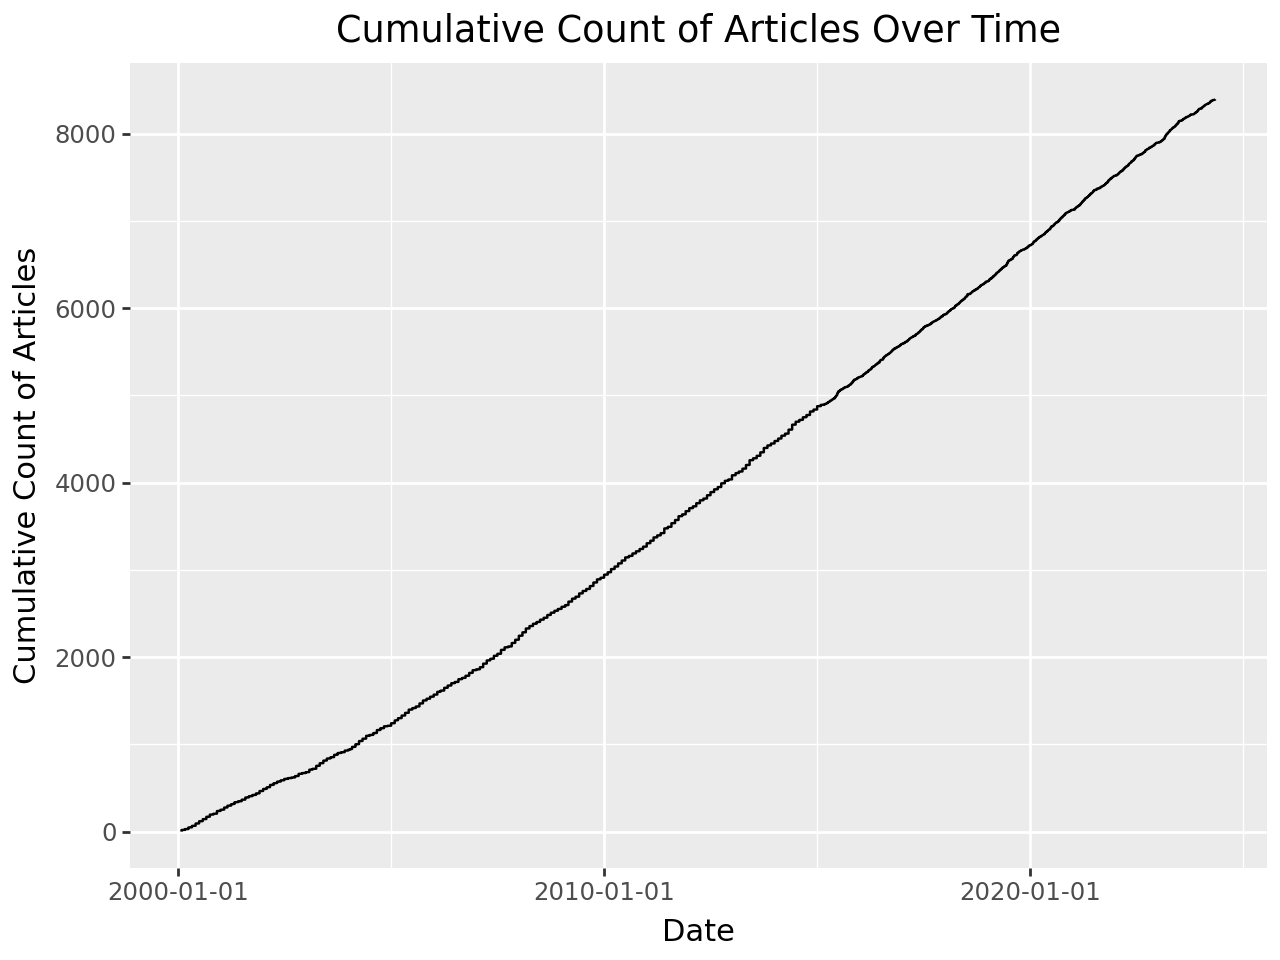

In [48]:
#docdt is a date in the form 2000-01-01. Create a plot with the cumulative number of articles over time

#create copy of prwp_processed_df

prwp_plot_df=prwp_processed_df.copy()
# Ensure 'docdt' is in datetime format
prwp_plot_df['date'] = pd.to_datetime(prwp_plot_df['docdt'])
#drop values with no date
prwp_plot_df = prwp_plot_df.dropna(subset=['date'])

# Sort the DataFrame by date
prwp_plot_df = prwp_plot_df.sort_values('date')

# Calculate the cumulative count of articles 
prwp_plot_df['cumulative_count'] = prwp_plot_df.reset_index().index

# Create the plot
(ggplot(prwp_plot_df)
 + aes(x='date', y='cumulative_count')
 + geom_line()
 + labs(x='Date', y='Cumulative Count of Articles', title='Cumulative Count of Articles Over Time'))


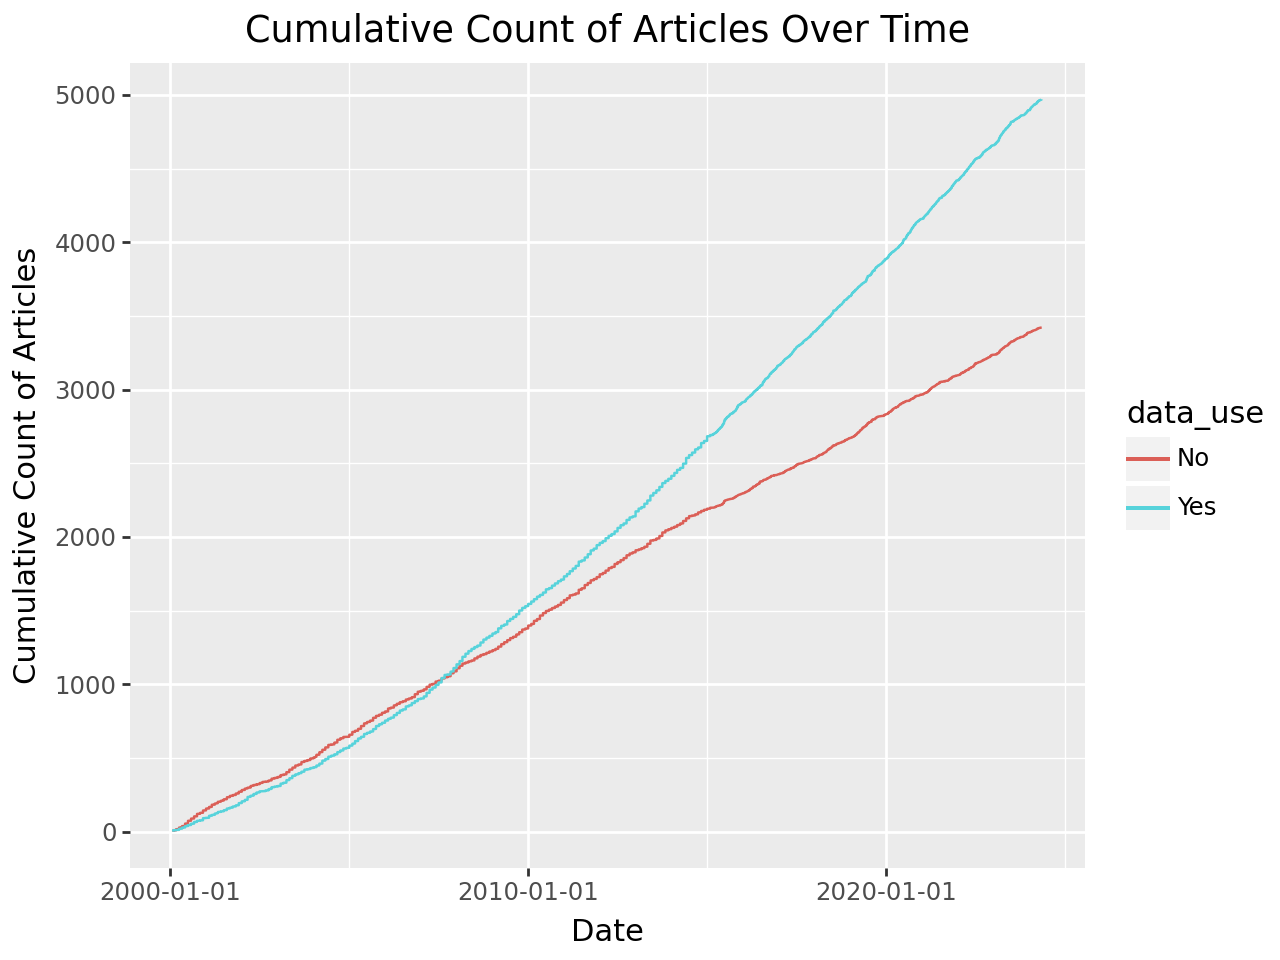

In [49]:
#do the same but add two separate lines for label: yes and label: no
#get cumulative accounts for just label yes
# Create separate dataframes for 'Yes' and 'No' labels
yes_df = prwp_plot_df[prwp_plot_df['data_use'] == 'Yes'].sort_values('date')
no_df = prwp_plot_df[prwp_plot_df['data_use'] == 'No'].sort_values('date')

# Calculate the cumulative count of articles for each label
yes_df['cumulative_count'] = yes_df.reset_index().index
no_df['cumulative_count'] = no_df.reset_index().index

#plot both using plotnine
# Concatenate the dataframes
df = pd.concat([yes_df, no_df])

# Create the plot
(ggplot(df)
 + aes(x='date', y='cumulative_count', color='data_use')
 + geom_line()
 + labs(x='Date', y='Cumulative Count of Articles', title='Cumulative Count of Articles Over Time'))


In [50]:
#get countries in iso3c
# use country converter to standarize country names
paper_index = list(prwp_processed_df.index) # this ist just a list of the index/CoreIDs

prwp_processed_df['iso3c'] = prwp_processed_df['count'].apply(lambda x: coco.convert([x], to='ISO3', src='regex', not_found='nf'))




nan not found in regex
nan not found in regex
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for Iceland,Chile
More than one regular expression match for

In [51]:
#add some exceptions for World, East Asia & Pacific, Latin America & Caribbean, Europe & Central Asia, Middle East & North Africa, Sub-Saharan Africa, North America, South Asia
#add codes for these regions as a new column called region
#create empty region column and fill in if region is found in count
# Define the regions and their codes
regions = {
    'World': 'WLD',
    'East Asia & Pacific': 'EAP',
    'Latin America & Caribbean': 'LAC',
    'Europe & Central Asia': 'EAP',
    'Middle East & North Africa': 'MNA',
    'Sub-Saharan Africa': 'SSA',
    'North America': 'NAC',
    'South Asia': 'SAR'
}

# Create a new 'region' column
prwp_processed_df['region'] = ''

prwp_processed_df['count'] = prwp_processed_df['count'].fillna('')

# Fill in the 'region' column
for region, code in regions.items():
    prwp_processed_df.loc[prwp_processed_df['count'].str.contains(region, flags=re.IGNORECASE), 'region'] = code

In [52]:
#save to csv
prwp_processed_df.to_csv(root_path + '/01_raw_data/prwp_papers/prwp_processed.csv')

In [53]:
# reshape the data so that the list of countries in 'iso3c' are put into separate dummy variables
# Create a list of unique countries
countries = prwp_processed_df['iso3c'].explode().unique()

# Create a new DataFrame with the countries as columns
countries_df = pd.DataFrame(index=prwp_processed_df.index, columns=countries)

# Fill the new DataFrame with dummy variables
for country in countries:
    countries_df[country] = prwp_processed_df['iso3c'].apply(lambda x: country in x).astype(int)

# Concatenate the new DataFrame with the original DataFrame
prwp_final_df = pd.concat([prwp_processed_df, countries_df], axis=1)

#do the same for the regions
# Create a list of unique regions
regions = prwp_processed_df['region'].unique()

# Create a new DataFrame with the regions as columns
regions_df = pd.DataFrame(index=prwp_processed_df.index, columns=regions)

# Fill the new DataFrame with dummy variables
for region in regions:
    regions_df[region] = prwp_processed_df['region'].apply(lambda x: region in x).astype(int)

# Concatenate the new DataFrame with the original DataFrame
prwp_final_df = pd.concat([prwp_final_df, regions_df], axis=1)

#save to csv
prwp_final_df.to_csv(root_path + '/01_raw_data/prwp_papers/prwp_final.csv')

In [54]:
#create a table counting the number of articles by country
# Create a new DataFrame to hold the counts
country_counts = pd.DataFrame(index=countries, columns=['Count'])

# Fill the DataFrame with the counts
for country in countries:
    country_counts.loc[country, 'Count'] = prwp_final_df[country].sum()

# Sort the DataFrame by count
country_counts = country_counts.sort_values('Count', ascending=False)

c:\Users\WB469649\Documents\Github\venv_github\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_point : Removed 10 rows containing missing values.
c:\Users\WB469649\Documents\Github\venv_github\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_text : Removed 10 rows containing missing values.
c:\Users\WB469649\Documents\Github\venv_github\Lib\site-packages\plotnine\layer.py:364: PlotnineWarning: geom_text : Removed 10 rows containing missing values.


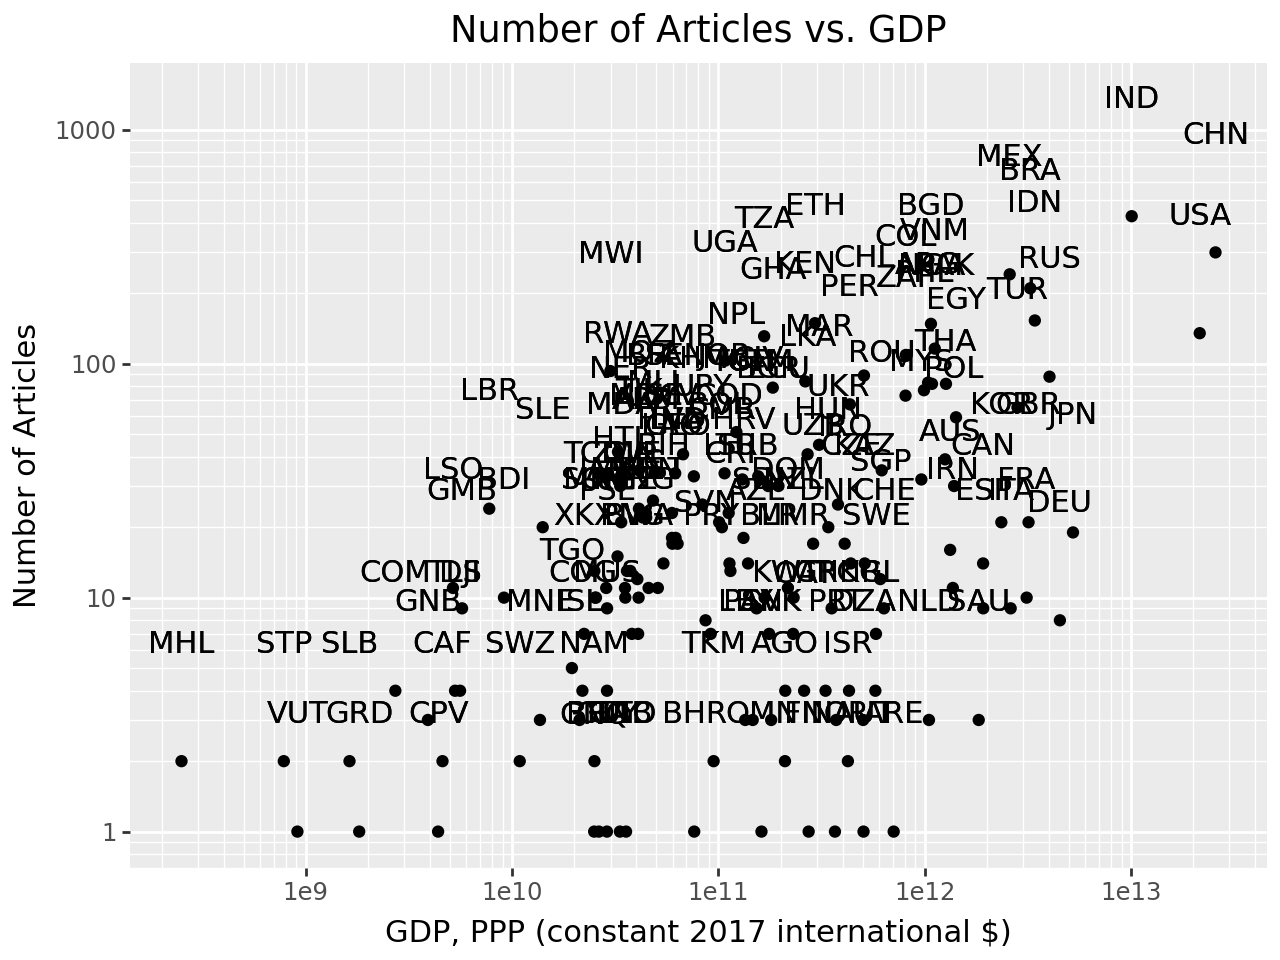

In [55]:
#get gdp per capita data from the worldbank api
import wbgapi as wb

# Get the GDP per capita data
gdp_df = wb.data.DataFrame(['NY.GDP.MKTP.PP.KD', 'SP.POP.TOTL'], 'all', mrv=1) # most recent  year

#now produce a scatterplot using plotnine of gdp against country_counts
# Merge the country counts and GDP per capita data
merged_df = country_counts.merge(gdp_df, left_index=True, right_on='economy')

#make index a column
merged_df = merged_df.reset_index()

#scatterplot
# Create the plot
(ggplot(merged_df)
 + aes(x='NY.GDP.MKTP.PP.KD', y='Count', label='economy')
 + geom_point()
 + geom_text(nudge_y=0.5)
 + scale_x_log10() 
 + scale_y_log10()
 + labs(x='GDP, PPP (constant 2017 international $)', y='Number of Articles', title='Number of Articles vs. GDP')
 + geom_text(nudge_y=0.5))


In [62]:
#ols regression table of counts on gdp 
import statsmodels.api as sm


merged_df['Count'] = pd.to_numeric(merged_df['Count'])
#drop NaN values
merged_df = merged_df.dropna(subset=['NY.GDP.MKTP.PP.KD', 'Count'])
# Define the dependent and independent variables
X = sm.add_constant(np.log(merged_df['NY.GDP.MKTP.PP.KD']))
y = np.log(merged_df['Count'])

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Get the summary of the model
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     47.70
Date:                Fri, 10 May 2024   Prob (F-statistic):           1.17e-10
Time:                        08:40:20   Log-Likelihood:                -258.48
No. Observations:                 159   AIC:                             521.0
Df Residuals:                     157   BIC:                             527.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -6.0541      1.247     -4.854      0.000      -8.518      -3.591
NY.GDP.MKTP.PP.KD     0.3354      0.049      6.906      0.000       0.239       0.431
==============================================================================
Omnibus:                        6.809   Durbin-Watson:                   0.460
Prob(Omnibus):                  0.033   Jarque-Bera (JB):                6.408
Skew:                          -0.433   Prob(JB):                       0.0406
Kurtosis:                       2.534   Cond. No.                         327.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [60]:
#convert Count to numeric
merged_df['Count'] = pd.to_numeric(merged_df['Count'])

TypeError: loop of ufunc does not support argument 0 of type numpy.int64 which has no callable log method